# Comparing PCA and LDA Techniques on the LFW Dataset for Dimensionality Reduction

# Import libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people

from numpy import linalg
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Define the MyPCA class

In [ ]:
class MyPCA:
  # Initialize the MyPCA class with the number of components and decomposition method
  def __init__(self, num_components, decomposition='eigen'):
    self.n_components = num_components
    self.decomposition = decomposition
    # Principal components
    self.components_ = None
    self.explained_variance_ratio_ = None
    self.explained_variance_ratio_all_ = None
    self.mean_ = None

  # Fit the PCA model to the data
  def fit(self, X_nxf, y=None):
    assert X_nxf.shape[1] >= self.n_components, "The number of features after reduction must be smaller than or equal to the number of features in the original data"
    # print("MyPCA.fit() is called. X.shape is {}. The number of features will be reduced from {} to {}.".format(X_nxf.shape, X_nxf.shape[1], self.n_components))

    # Center data around mean
    self.mean_ = np.mean(X_nxf, axis=0)
    A = X_nxf - self.mean_

    # Transform the matrix A to A.T so that each row represents a different feature and each column represents a different data sample.
    cov_A = np.cov(A.T)

    if self.decomposition == "eigen":
      # Calculate eigenvalues and eigenvectors
      eigenvalues, eigenvectors = linalg.eigh(cov_A)
      # Sort eigenvectors by eigenvalues in descending order
      idx = eigenvalues.argsort()[::-1]
      sorted_eigenvalues = eigenvalues[idx]
      self.explained_variance_ratio_ = sorted_eigenvalues[:self.n_components] / eigenvalues.sum()
      self.explained_variance_ratio_all_ = sorted_eigenvalues / eigenvalues.sum()
      sorted_eigenvectors = eigenvectors[:, idx]
      self.components_ = sorted_eigenvectors[:, :self.n_components]
    elif self.decomposition == "svd":
      # Compute the SVD
      U, S, Vh = np.linalg.svd(A, full_matrices=False)
      # Compute explained variance ratios
      variances = S**2 / (len(X_nxf) - 1)
      total_variance = np.sum(variances)
      self.explained_variance_ratio_ = variances[:self.n_components] / total_variance
      self.explained_variance_ratio_all_ = variances / total_variance
      self.components_ = Vh[:self.n_components].T
    return self

  # Transform the data using the fitted PCA model
  def transform(self, X_nxf):
    assert X_nxf.shape[1] >= self.n_components, "The number of features after reduction must be smaller than or equal to the number of features in the original data"

    # Center data around mean
    A = X_nxf - self.mean_
    # Project the data onto the principal components
    return A @ self.components_


## Test the MyPCA class with mini data

This section compares the MyPCA class with sklearn's PCA class using the following mini_data:

```Python
mini_data = np.array([[1, 1, 10],
                      [1, 2, 20],
                      [1, 3, 30]])
```

The mini_data array consists of three samples, each with three dimensions. PCA enables dimensionality reduction while aiming to retain as much of the original dataset's variance as possible. In this dataset, the first column contains identical values across all samples, providing no unique feature variance. In addition, the second column is linearly dependent on the third column. Therefore, using just the third column for analysis can still keep the main features of the original dataset's variance. After sorting, the `explained_variance_ratio_` would be [1, 0, 0].

In [ ]:
# Compare the MyPCA class with sklearn's PCA class using this mini-data
mini_data = np.array([[1, 1, 10],
                      [1, 2, 20],
                      [1, 3, 30]])
num_components = 3

# The MyPCA class
mypca = MyPCA(num_components)
mypca.fit(mini_data)
X_mypca = mypca.transform(mini_data)
print("explained_variance_ratio_: ", mypca.explained_variance_ratio_)

# The sklearn PCA class
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(mini_data)

# Assert that the MyPCA class emits the same result as the sklearn PCA.
for col in range(num_components):
  assert np.allclose(X_mypca[:, col], X_pca[:, col]) or np.allclose(X_mypca[:, col] * -1, X_pca[:, col]), "The reduced data of MyPCA differs from that of Sklearn PCA."
assert np.allclose(mypca.explained_variance_ratio_, pca.explained_variance_ratio_), "The variance ratio of MyPCA differs from that of Sklearn PCA."

explained_variance_ratio_:  [1. 0. 0.]


# Download LFW dataset

* The Labeled Faces in the Wild face recognition dataset (https://scikit-learn.org/0.19/datasets/labeled_faces.html)

In [ ]:
# Use data from classes with a sample size of at least 70.
# Resize the image by 0.4 times.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape # 1288, 50, 37
X = lfw_people.data
y = lfw_people.target
n_classes = lfw_people.target_names.shape[0] # 7

In [ ]:
# Prepare two types of datasets:
#  Dataset 1: the original dataset of X and y
#  Dataset 2: a balanced dataset where each class has an equal number of samples.

# Dataset 1
X_lfw_1 = X
y_lfw_1 = y

# Dataset 2
unique, counts = np.unique(y, return_counts=True)
min_sample = np.min(counts)
# Select min_sample images from each class.
selected_indices = []
for i in range(n_classes):
  indices = np.where(y == i)[0]
  selected_indices.extend(indices[:min_sample])
assert len(selected_indices) == min_sample * n_classes, "The number of selected images is unexpected."
X_lfw_2 = X[selected_indices]
y_lfw_2 = y[selected_indices]

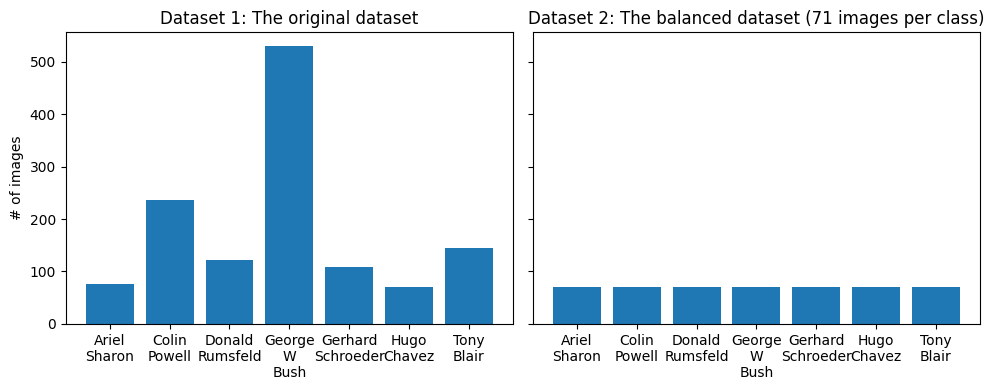

In [ ]:
# Visualize the two datasets in bar charts.
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, tight_layout=True)
x_labels = [re.sub(' ', '\n', name) for name in lfw_people.target_names]

ax[0].bar(x_labels, np.unique(y_lfw_1, return_counts=True)[1])
ax[1].bar(x_labels, np.unique(y_lfw_2, return_counts=True)[1])

ax[0].title.set_text("Dataset 1: The original dataset")
ax[1].title.set_text("Dataset 2: The balanced dataset ({} images per class)".format(min_sample))
ax[0].set_ylabel("# of images");

# Determine the number of components based on the cumulative variance ratio

Before making inferences with k-NN, the variance contribution of the PCA component is examined.

In [ ]:
# MyPCA class
mypca = MyPCA(100) # Regardless of the number of components set here, "explained_variance_ratio_all_" stores all ratios.
mypca.fit(X)
mypca_cumsum = np.cumsum(mypca.explained_variance_ratio_all_)[:300]
n_component_075 = np.argmax(mypca_cumsum > 0.75)
n_component_085 = np.argmax(mypca_cumsum > 0.85)
n_component_095 = np.argmax(mypca_cumsum > 0.95)
n_component_09785 = np.argmax(mypca_cumsum > 0.9785)
print([n_component_075, n_component_085, n_component_095, n_component_09785])

# sklearn LDA class
lda = LDA(n_components=None).fit(X, y)
lda_cumsum = np.cumsum(lda.explained_variance_ratio_)

[22, 53, 166, 287]


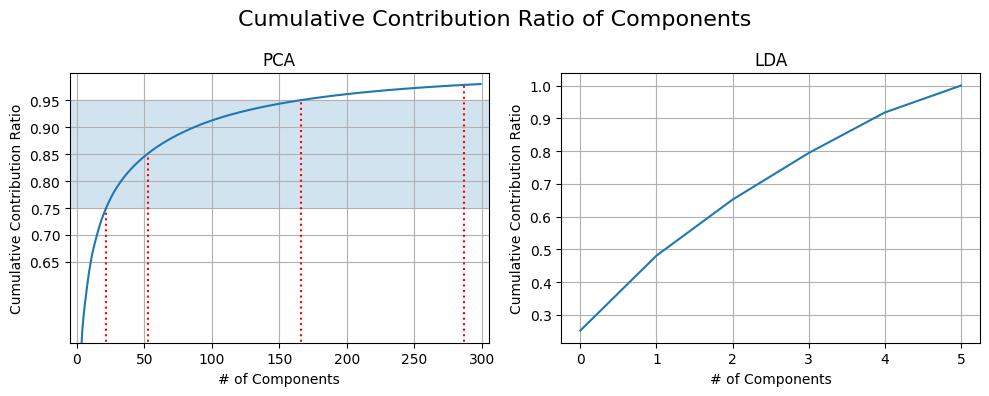

In [ ]:
# Plot the cumulative contribution ratios for PCA and LDA
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
fig.suptitle('Cumulative Contribution Ratio of Components', fontsize=16)

ax[0].fill_between(np.arange(-5, 310), 0.75, 0.95, alpha=0.2)
ax[0].grid(True);
ax[1].grid(True);
ax[0].axis([-5, 305, 0.5, 1])
ax[0].set_yticks(np.arange(0.65, 1, 0.05))
ax[0].plot([n_component_075, n_component_075], [0, 0.75], linestyle='dotted', color='r')
ax[0].plot([n_component_085, n_component_085], [0, 0.85], linestyle='dotted', color='r')
ax[0].plot([n_component_095, n_component_095], [0, 0.95], linestyle='dotted', color='r')
ax[0].plot([n_component_09785, n_component_09785], [0, 0.9785], linestyle='dotted', color='r')

ax[0].plot(mypca_cumsum)
ax[1].plot(lda_cumsum)

ax[0].title.set_text("PCA")
ax[1].title.set_text("LDA")
ax[0].set_ylabel("Cumulative Contribution Ratio")
ax[0].set_xlabel("# of Components")
ax[1].set_ylabel("Cumulative Contribution Ratio")
ax[1].set_xlabel("# of Components");

# Perform face recognition using a k-NN classifier

Hyperparameters for PCA and LDA are as follows:
* Method: {PCA, LDA}
* Dataset: {Dataset 1(original), Dataset 2(class-balanced)}
* n_components for PCA: {22(75%), 53(85%), 166(95%), 287(97.85%)}
* n_components for LDA: {6(100%)}


Hyperparameters for k-NN are as follows:
* n_neigbour: {9, 11, 13}
* knn merics: {'l1', 'l2'}


In [ ]:
# N-fold nested cross-validation function
def nested_cross_validation_knn(pipeline, X_dataset, y_dataset):
  # Set the grid of hyperparameters for kNN
  param_grid = {
      'knn__n_neighbors': [9, 11, 13],
      'knn__metric': ['l1', 'l2']
  }

  # Create inner cross-validation (CV) for hyperparameter tuning using grid search
  inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
  grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy')

  # Create outer CV for model evaluation
  outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

  outer_scores = []
  best_params = []
  for train_index, test_index in outer_cv.split(X_dataset, y_dataset):
      X_train, X_test = X_dataset[train_index], X_dataset[test_index]
      y_train, y_test = y_dataset[train_index], y_dataset[test_index]

      # Perform hyperparameter tuning and train the model using the inner CV
      grid_search.fit(X_train, y_train)

      # Evaluate and store the score of the best model on the outer test set
      best_model = grid_search.best_estimator_
      outer_scores.append(best_model.score(X_test, y_test))
      best_params.append(grid_search.best_params_)

  return np.mean(outer_scores), best_params

In [ ]:
# Perform PCA+kNN and LDA+kNN with different hyperparameters
pca_components_thresholds = [n_component_075, n_component_085, n_component_095, n_component_09785]
# (dataset_id, X, y)
datasets = [(1, X_lfw_1, y_lfw_1), (2, X_lfw_2, y_lfw_2)]

# PCA+kNN
results_pca = []
best_params_pca = []
for dataset_id, X_dataset, y_dataset in datasets:
  for n_components in pca_components_thresholds:
    pipeline = Pipeline([
      ('mypca', MyPCA(n_components)),
      ('knn', KNeighborsClassifier())
      ])
    accuracy, best_params = nested_cross_validation_knn(pipeline, X_dataset, y_dataset)
    results_pca.append({'Method': 'PCA + KNN', 'Dataset': dataset_id, 'n_components': n_components, 'Accuracy': accuracy})
    for params in best_params:
      params['Method'] = 'PCA + KNN'
      params['Dataset'] = dataset_id
      params['n_components'] = n_components
      best_params_pca.append(params)

# LDA+kNN
results_lda = []
best_params_lda = []
for dataset_id, X_dataset, y_dataset in datasets:
  pipeline = Pipeline([
      ('lda', LDA(n_components=None)),
      ('knn', KNeighborsClassifier())
      ])
  accuracy, best_params = nested_cross_validation_knn(pipeline, X_dataset, y_dataset)
  results_lda.append({'Method': 'LDA + KNN', 'Dataset': dataset_id, 'n_components': n_classes - 1, 'Accuracy': accuracy})
  for params in best_params:
    params['Method'] = 'LDA + KNN'
    params['Dataset'] = dataset_id
    params['n_components'] = n_classes - 1
    best_params_lda.append(params)

# Create a result dataframe
df_results = pd.DataFrame(results_pca + results_lda)

In [ ]:
# Show the result
df_results

,Method,Dataset,n_components,Accuracy
0,PCA + KNN,1,22,0.545821
1,PCA + KNN,1,53,0.625793
2,PCA + KNN,1,166,0.623458
3,PCA + KNN,1,287,0.611818
4,PCA + KNN,2,22,0.426444
5,PCA + KNN,2,53,0.474626
6,PCA + KNN,2,166,0.508990
7,PCA + KNN,2,287,0.492949
8,LDA + KNN,1,6,0.702648
9,LDA + KNN,2,6,0.752545


In [ ]:
# Count knn__metric(l1 or l2) for each combination of the Method and the Dataset
df = pd.DataFrame(best_params_pca+best_params_lda)
df.groupby(['Method', 'Dataset'], as_index=False, sort=False)['knn__metric'].value_counts().sort_values('Method',ascending=False)

,Method,Dataset,knn__metric,count
3,PCA + KNN,1,l1,20
4,PCA + KNN,2,l1,20
0,LDA + KNN,1,l2,5
1,LDA + KNN,2,l2,3
2,LDA + KNN,2,l1,2
